# Rating Engine Optimisation (REO) for Ecommerce

The following is a study on how various aspect of marketing and customer service factors may influence customer's satisfaction as reflected in their rating of a product.       
     The findings are used to ultimately develop a model that can help ecommerce companies determine their product's potential rating based on their supplementary actions, separate of product pricing. This allows companies to optimise their marketing strategy in improving product ratings without the need for aggressive price strategies that may reduce profit margin. This is an often neglected field of study that receives less limelight in comparison to pricing strategies and is the reson why we decided to focus on this for our project.

## Data Preparation

In the following codes, numerous processes are done to achieve a cleaned master data that contains all relevant predictors and response to build our machine learning model on.

### Importing the Dataset

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

In [ ]:
import datetime

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
olist_orders_dataset = pd.read_csv("/content/drive/MyDrive/CZ1115 Mini Project/Brazilian E-Commerce Public Dataset by Olist/archive/olist_orders_dataset.csv")

In [ ]:
olist_order_reviews_dataset = pd.read_csv("/content/drive/MyDrive/CZ1115 Mini Project/Brazilian E-Commerce Public Dataset by Olist/archive/olist_order_reviews_dataset.csv")

In [ ]:
olist_order_items_dataset = pd.read_csv("/content/drive/MyDrive/CZ1115 Mini Project/Brazilian E-Commerce Public Dataset by Olist/archive/olist_order_items_dataset.csv")

In [ ]:
olist_products_dataset = pd.read_csv("/content/drive/MyDrive/CZ1115 Mini Project/Brazilian E-Commerce Public Dataset by Olist/archive/olist_products_dataset.csv")

Datasets for Olist are segregated into respective subsets of CSV_files containing information about Orders, Order Review and Products. To extract the data pertinent to our analysis we first extracted the following 4 datasets:   
**olist_orders_dataset / olist_order_reviews_dataset / olist_order_items_dataset / olist_products_dataset** 

### Removal of NULL and Duplicate fields

Upon inspection of the dataset, we observe that there are multiple instances of NULL value or duplicates. 

Invalid data were eliminated through removing missing value and duplicates with (dropna) and (drop_duplicates) from the panda dataframe.

We tracked the dataset's dimensions and the natural reduction in dimension shown indicates that erroneous data have been successfully removed.

In [ ]:
olist_orders_dataset.shape

(99441, 8)

In [ ]:
olist_orders_dataset_cleaned = olist_orders_dataset.dropna(axis = "rows", how = "any", subset = ["order_id", "order_estimated_delivery_date", "order_delivered_customer_date", "order_approved_at"])
olist_orders_dataset_cleaned = olist_orders_dataset_cleaned.drop_duplicates(subset = ["order_id"], keep = False)
olist_orders_dataset_cleaned.shape

(96462, 8)

In [ ]:
olist_order_reviews_dataset.shape

(100000, 7)

In [ ]:
olist_order_reviews_dataset_cleaned = olist_order_reviews_dataset.dropna(axis = "rows", how = "any", subset = ["order_id", "review_score"])
olist_order_reviews_dataset_cleaned = olist_order_reviews_dataset_cleaned.drop_duplicates(subset = ["order_id"], keep = False)
olist_order_reviews_dataset_cleaned.shape

(98886, 7)

In [ ]:
olist_order_items_dataset.shape

(112650, 7)

In [ ]:
olist_order_items_dataset_cleaned = olist_order_items_dataset.dropna(axis = "rows", how = "any", subset = ["order_id", "product_id"])
olist_order_items_dataset_cleaned = olist_order_items_dataset_cleaned.drop_duplicates(subset = ["order_id"], keep = False)
olist_order_items_dataset_cleaned.shape

(88863, 7)

In [ ]:
olist_products_dataset.shape

(32951, 9)

In [ ]:
olist_products_dataset_cleaned = olist_products_dataset.dropna(axis = "rows", how = "any", subset = ["product_name_lenght", "product_description_lenght", "product_photos_qty", "product_category_name"])
olist_products_dataset_cleaned.shape

(32341, 9)

Finally, we merged the existing datasets based on their specified corresponding key according to the Kaggle E-Commerce Public Dataset by Olist. This meant that we merged the cleaned datasets of orders, reviews and order_item based on **order_id** in addition to order_item and products based on **product_id**. The result is a single master dataframe containing the relevant merged datasets.

In [ ]:
master = olist_orders_dataset_cleaned.merge(olist_order_reviews_dataset_cleaned, how = "inner", on = "order_id")
master.shape

(95929, 14)

In [ ]:
master = master.merge(olist_order_items_dataset_cleaned, how = "inner", on = "order_id")
master.shape

(86367, 20)

In [ ]:
master = master.merge(olist_products_dataset_cleaned, how = "inner", on = "product_id")
master.shape

(85143, 28)

### Generating New Columns

In selecting predictors that could contribute to the review score, we noticed 2 potential predictors **delivery duration** and **deviation from expected delivery date** not present in the dataset. To improve our model accuracy, we generated 2 new columns in the master dataframe, "delivery_duration" and "deviation_from_expectation"

In [ ]:
master = master[master["order_status"] == "delivered"]

In [ ]:
def calc_duration(first_date, second_date):
    first_date = datetime.datetime.strptime(first_date, "%Y-%m-%d %H:%M:%S")
    second_date = datetime.datetime.strptime(second_date, "%Y-%m-%d %H:%M:%S")
    duration = second_date - first_date
    return duration.days

In generating the new columns, we implemented a function to calculate the duration given a first and second date. Data where order has not been delivered were removed to account for all product delivery duration and deviation from expectation duration upon the date when product is received.

In [ ]:
master["delivery_duration"] = master.apply(lambda row: calc_duration(row["order_approved_at"], row["order_delivered_customer_date"]), axis = 1)

In [ ]:
master["deviation_from_expectation"] = master.apply(lambda row: calc_duration(row["order_estimated_delivery_date"], row["order_delivered_customer_date"]), axis = 1)

deviation from expected delivery ranged from negative to positive. Where a negative number (eg. -2) indicates that the delivery occurred 2 days earlier than the expected delivery date and a positive number (eg. +2) indicates that the delivery occurred 2 days later than expected. 

In [ ]:
master.columns.values #check all columns of master dataset to see if new column (deviation_from_expectation) were added 

array(['order_id', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'delivery_duration',
       'deviation_from_expectation'], dtype=object)

As a sanity check, we observed the columns of our finalised master dataframe. This allowed us to identify the the 2 new columns "delivery_duration" and "deviation_from_expectation" has been successfully generated and the master data is cleaned and ready for exploratory analysis.

## Exploratory Analysis

In this portion we preform statistical exploration and visualization of our response and predictor variables. To gain better insights on their relation. Statistical findings in our markdowns are rounded to 2 decimal place for its accuracy.

### Response Variable: Product Rating

In [ ]:
master["review_score"].describe()

count    85138.000000
mean         4.203399
std          1.240464
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64

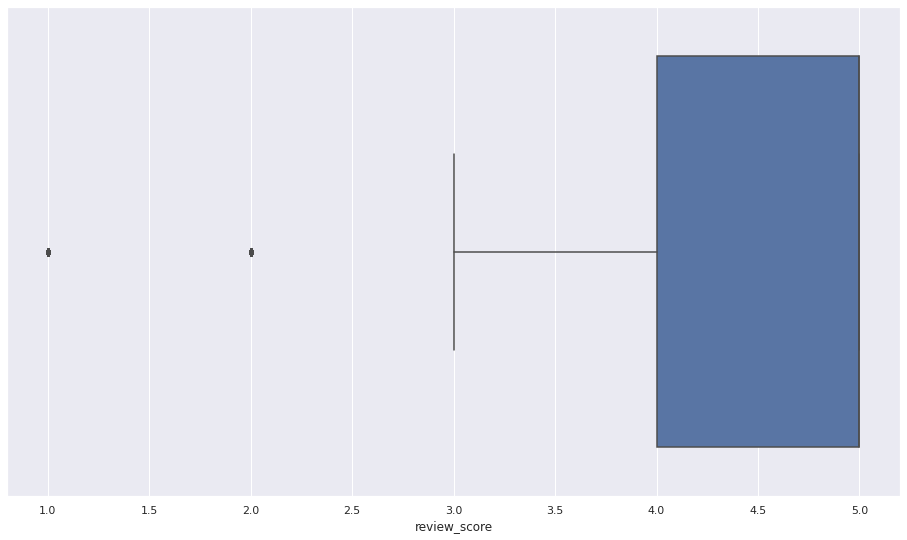

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "review_score")

From the boxplot of product rating, we can see that a huge percentage of the products have relatively high review scores with the lower quartile (Q1) at 3.0. There is a negative skew distribution With a mean of 4.20 and median of 5.00 which as products tends toward high review score or rating.

In [ ]:
master["review_score"].value_counts()

5    51303
4    17061
1     7407
3     6969
2     2398
Name: review_score, dtype: int64

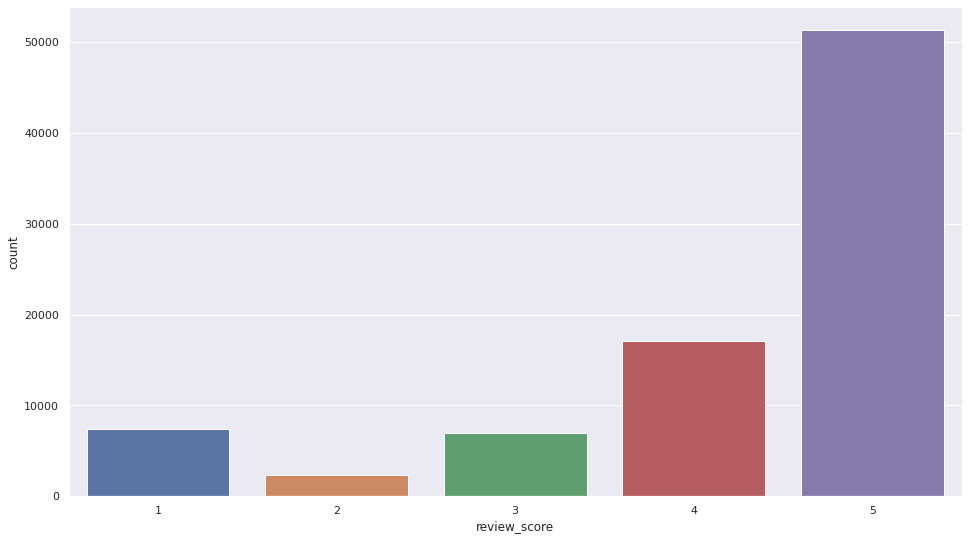

In [ ]:
plt.figure(figsize=(16, 9))
sb.countplot(data = master, x = "review_score")

The distribution in count for the different ratings is visualised above. With a rating of 5 having the highest count. This shows signs of an imbalanced review score or rating.

### Predictor Variable 1: Delivery Time

In [ ]:
master["delivery_duration"].describe()

count    85138.000000
mean        11.718680
std          9.593928
min         -7.000000
25%          6.000000
50%          9.000000
75%         15.000000
max        208.000000
Name: delivery_duration, dtype: float64

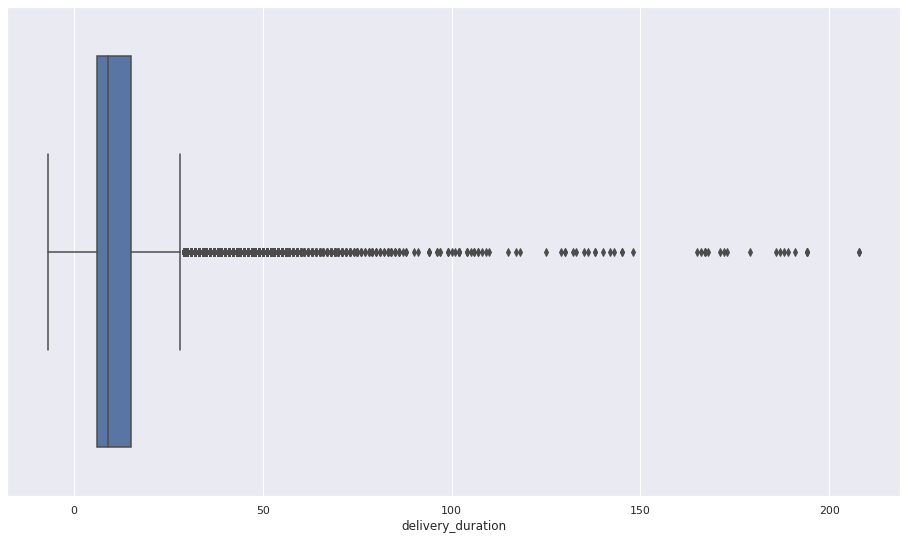

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "delivery_duration")

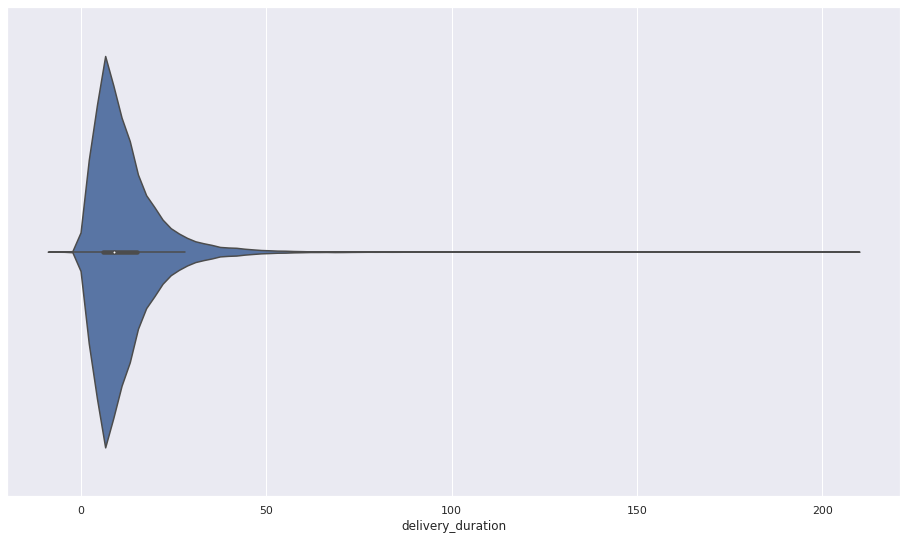

In [ ]:
plt.figure(figsize=(16, 9))
sb.violinplot(data = master, x = "delivery_duration")

For the distribution of delivery time, it is observed that it has a lesser median of 9.00 days while a mean of 11.72 days. there is a standard deviation of 9.59 days. There is a positive skew distribution for the violin and box plot




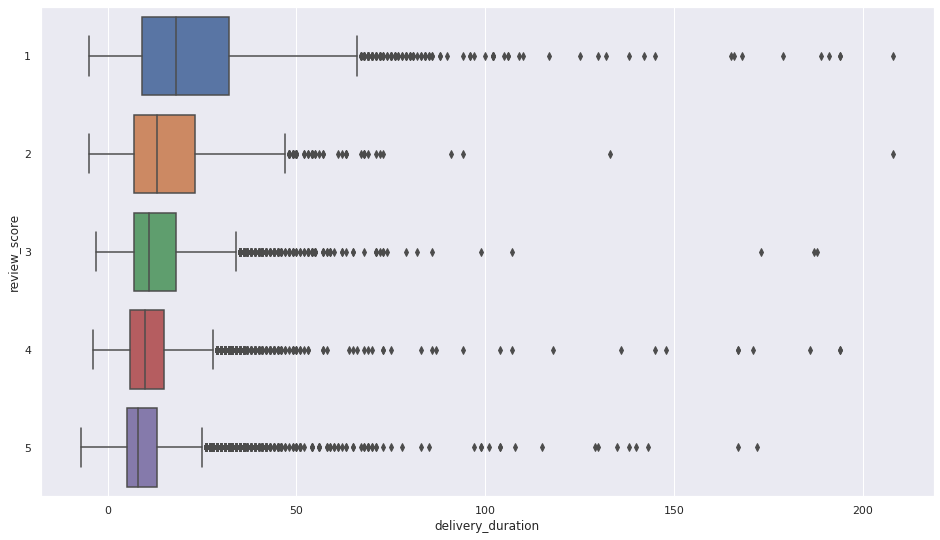

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "delivery_duration", y = "review_score", orient = "h")

It can be observed that the higher the rating or review score the lower its median for delivery duration from the box plot above 

### Predictor Variable 2: Deviation from Estimated Delivery Date

In [ ]:
master["deviation_from_expectation"].describe()

count    85138.000000
mean       -11.754152
std         10.198128
min       -140.000000
25%        -17.000000
50%        -12.000000
75%         -7.000000
max        188.000000
Name: deviation_from_expectation, dtype: float64

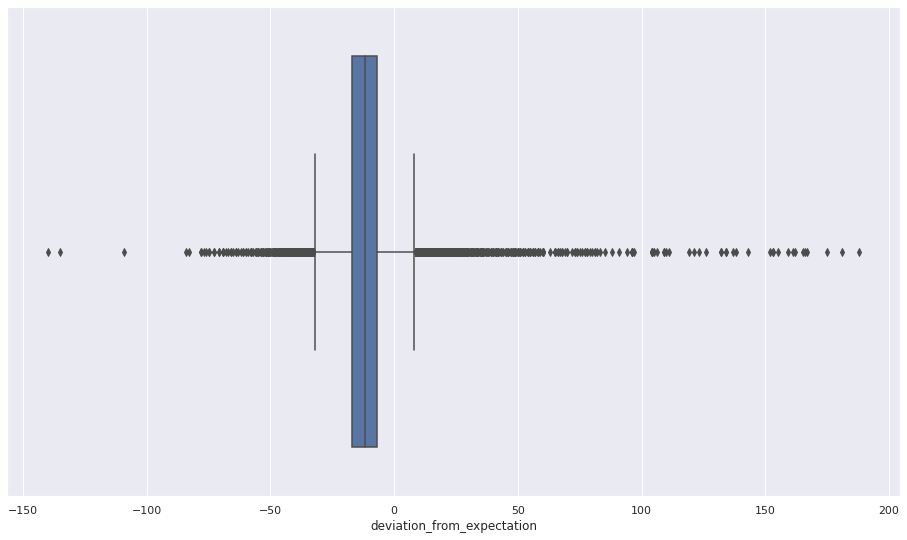

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "deviation_from_expectation")

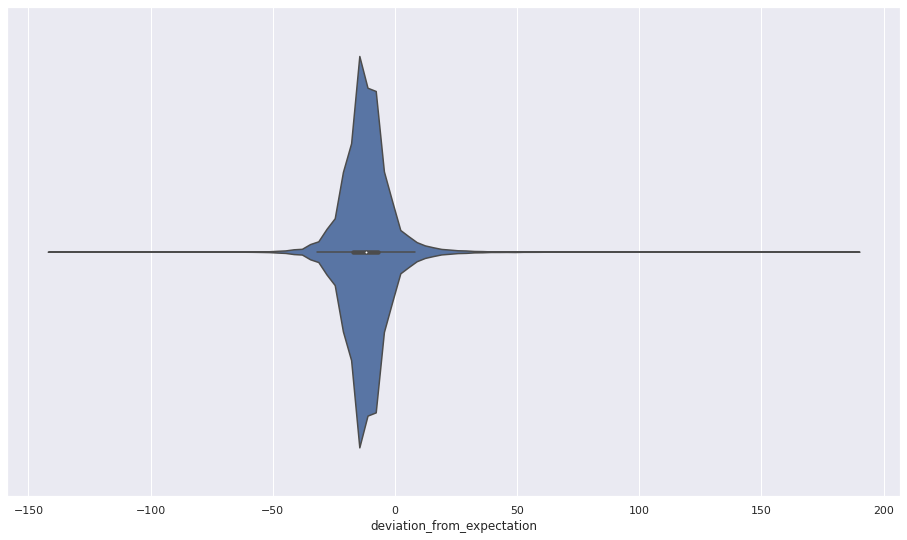

In [ ]:
plt.figure(figsize=(16, 9))
sb.violinplot(data = master, x = "deviation_from_expectation")

For the distribution of the deviation from the estimated delivery date, it is observed that it has a lesser median of -12.00 while a mean of -11.75. There is a standard deviation of 657.05. There is a normal distribution for the violin and box plot.

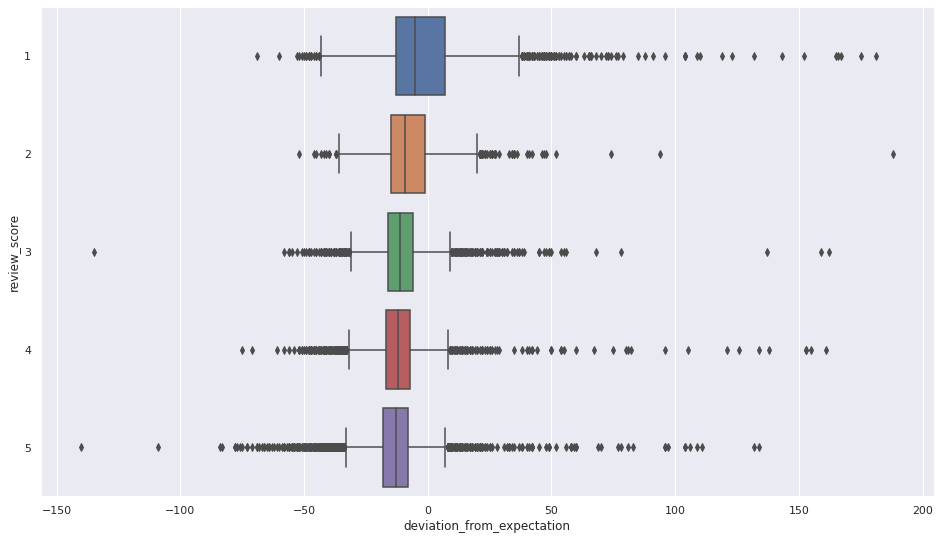

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "deviation_from_expectation", y = "review_score", orient = "h")

It can be observed that the higher rating or review score the lower its median for the deviation from expectated delivery date from the box plot above 

### Predictor Variable 3: Length of Product Name

In [ ]:
master["product_name_lenght"].describe()

count    85138.000000
mean        48.909735
std          9.966581
min          5.000000
25%         43.000000
50%         52.000000
75%         57.000000
max         76.000000
Name: product_name_lenght, dtype: float64

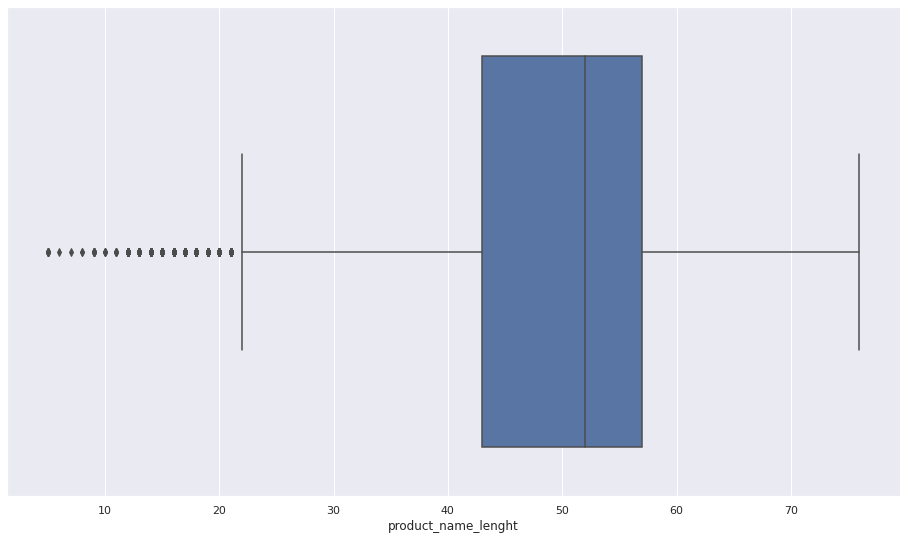

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "product_name_lenght")

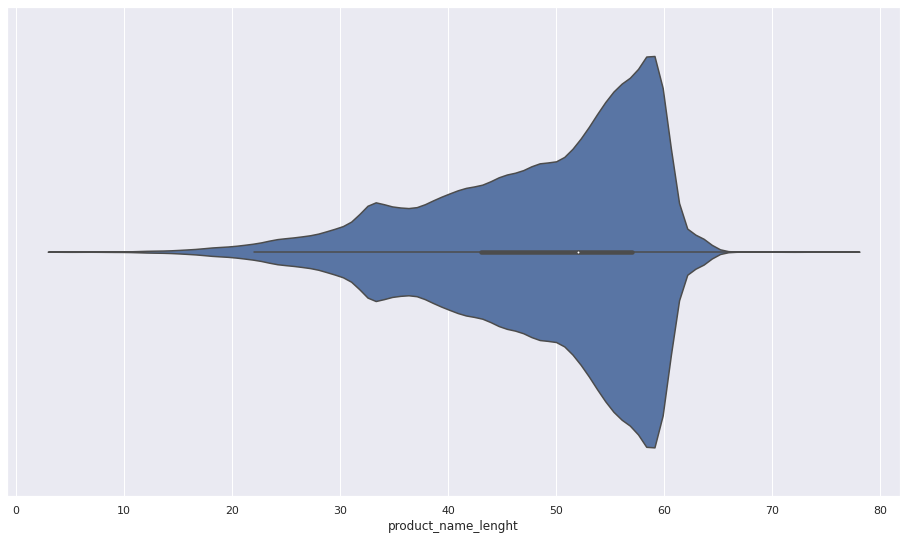

In [ ]:
plt.figure(figsize=(16, 9))
sb.violinplot(data = master, x = "product_name_lenght")

For the distribution of length of product name, it is observed that it has a greater median of 52.00 while a mean of 48.91. there is a standard deviation of 9.97. There is a negative skew distribution for the violin and box plot.

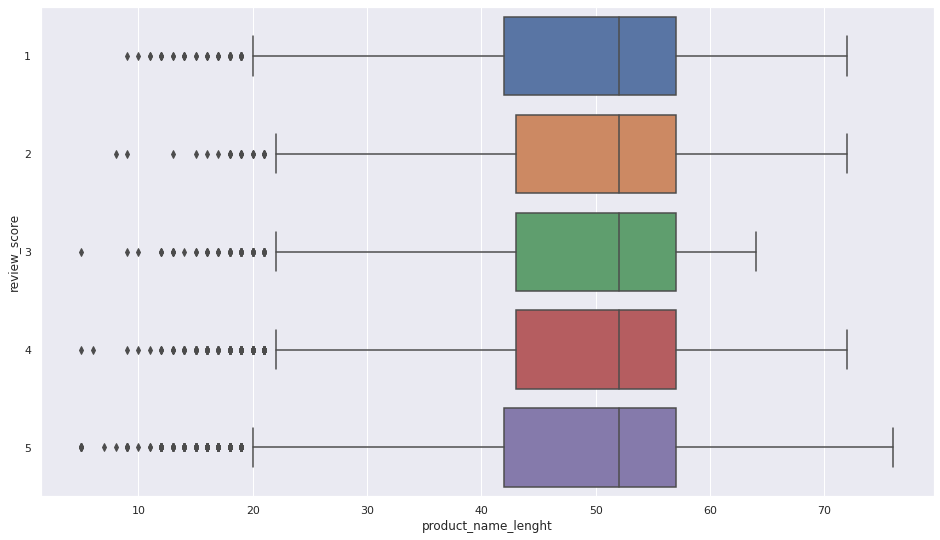

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "product_name_lenght", y = "review_score", orient = "h")

It can be observed that the higher rating or review score there is little change in median for the length of product name from the box plot above 

### Predictor Variable 4: Length of Product Description

In [ ]:
master["product_description_lenght"].describe()

count    85138.000000
mean       801.000810
std        657.049803
min          4.000000
25%        354.000000
50%        614.000000
75%       1003.000000
max       3992.000000
Name: product_description_lenght, dtype: float64

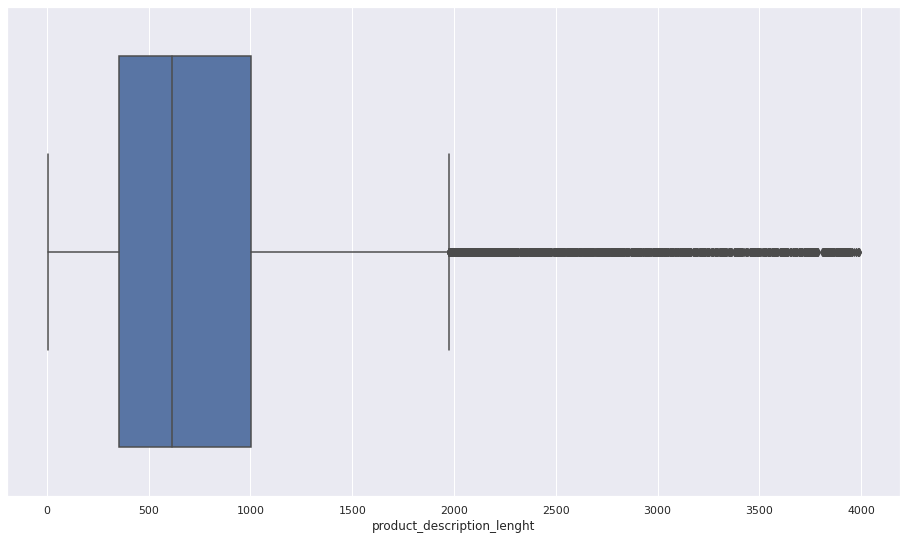

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "product_description_lenght")

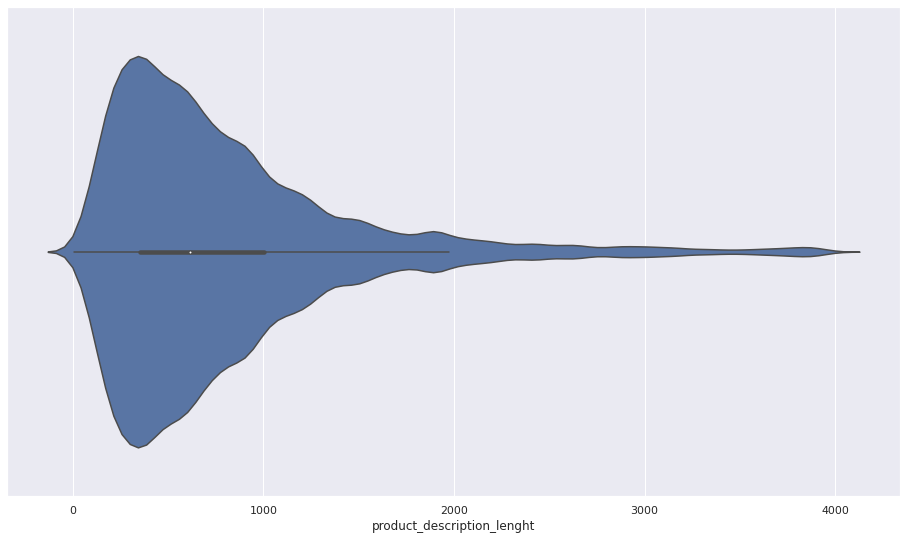

In [ ]:
plt.figure(figsize=(16, 9))
sb.violinplot(data = master, x = "product_description_lenght")

For the distribution of length of product description, it is observed that it has a lesser median of 614.00 while a mean of 801.00. There is a standard deviation of 657.05. There is a positive skew distribution for the violin and box plot.

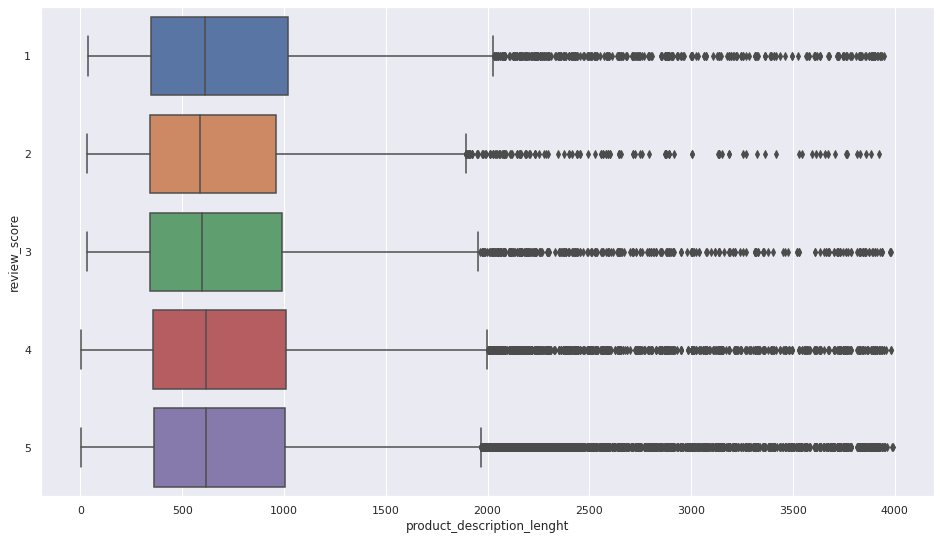

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "product_description_lenght", y = "review_score", orient = "h")

It can be observed that the higher rating or review score there is little change in its median for the length of product description from the box plot above 

### Predictor Variable 5: Number of Product Photos

In [ ]:
master["product_photos_qty"].describe()

count    85138.000000
mean         2.284832
std          1.764234
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: product_photos_qty, dtype: float64

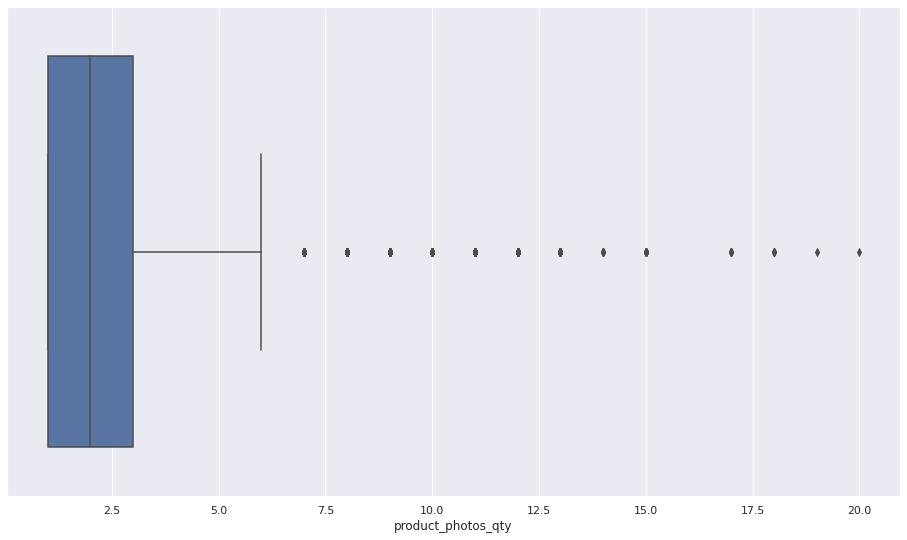

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "product_photos_qty")

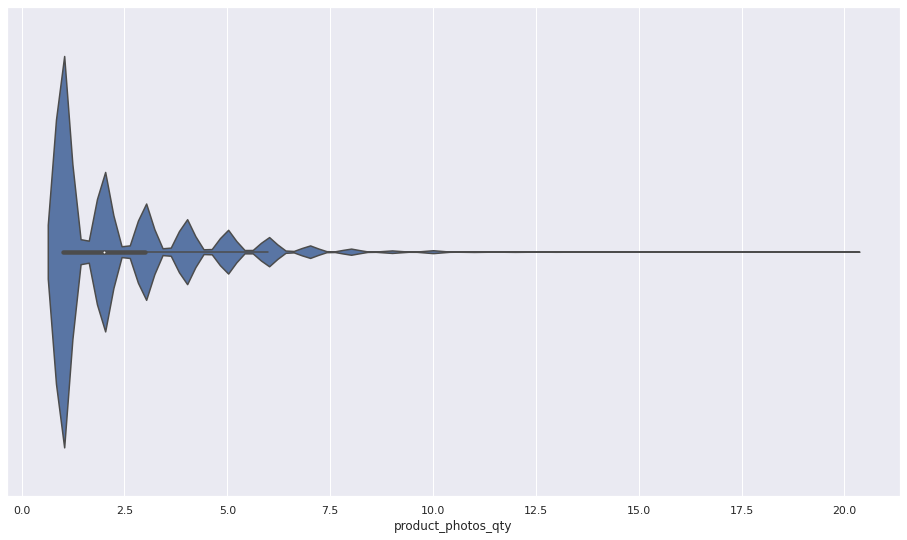

In [ ]:
plt.figure(figsize=(16, 9))
sb.violinplot(data = master, x = "product_photos_qty")

For the distribution of number of product photos, it is observed that it has a lesser median of 2.00 while a mean of 2.28. There is a standard deviation of 1.76. There is a positive skew distribution for the violin and box plot.

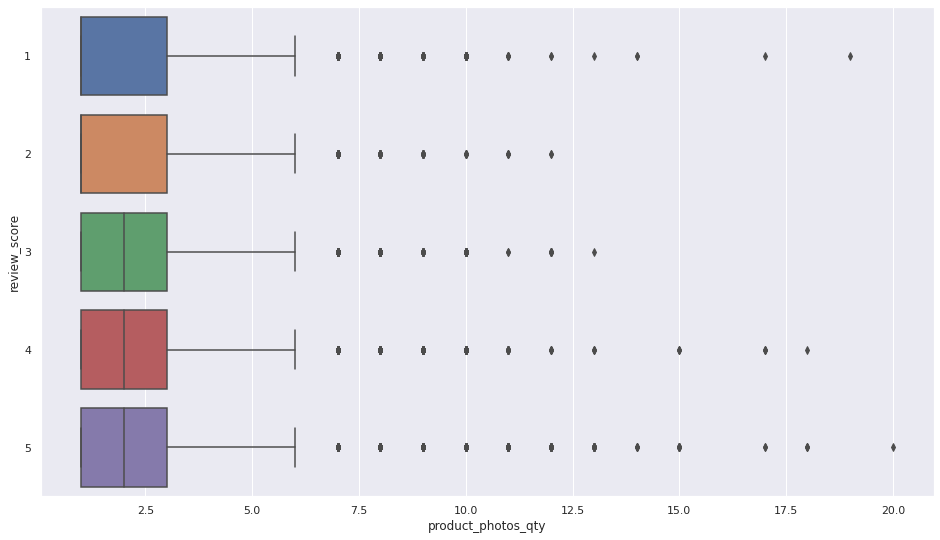

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "product_photos_qty", y = "review_score", orient = "h")

It can be observed that the higher rating or review score there is little change in its median for the number of product photos from the box plot above 

### Predictor Variable 6: Freight Value

In [ ]:
master["freight_value"].describe()

count    85138.000000
mean        20.376284
std         15.971871
min          0.000000
25%         13.430000
50%         16.500000
75%         21.390000
max        409.680000
Name: freight_value, dtype: float64

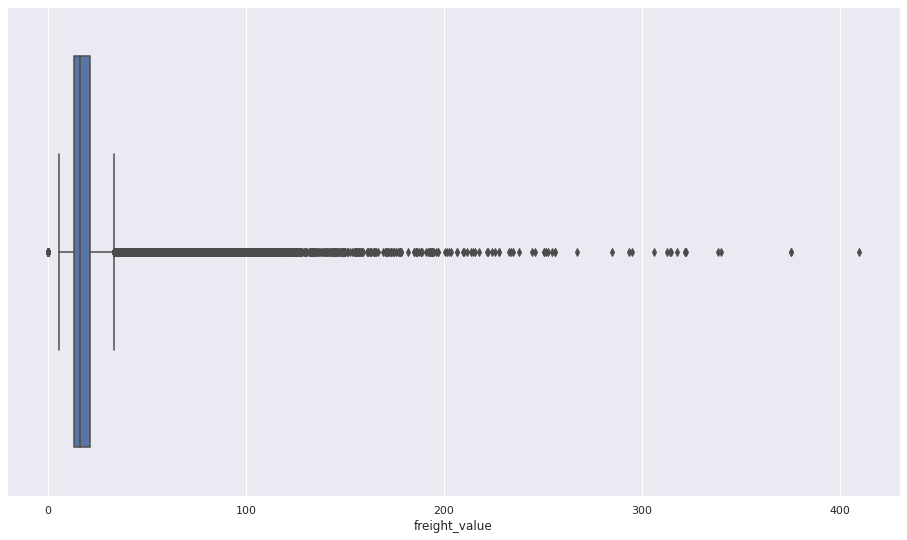

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "freight_value")

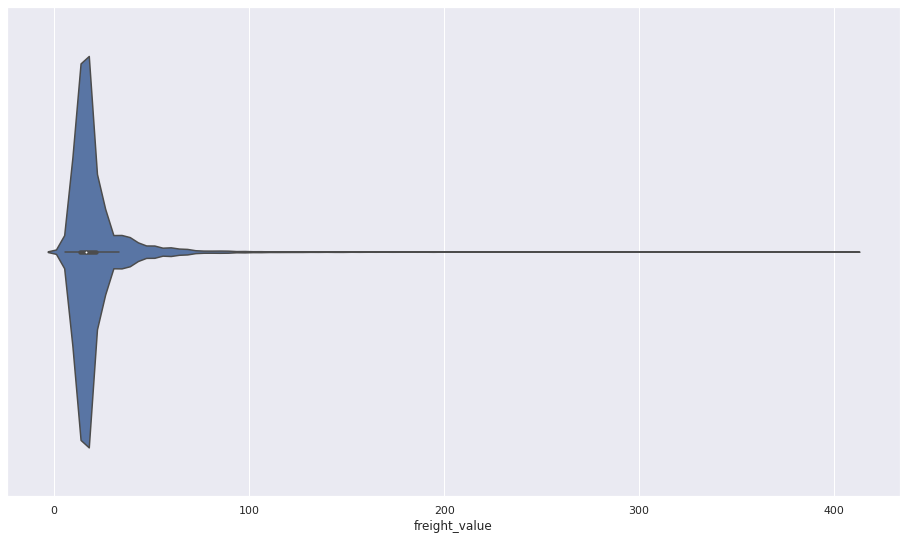

In [ ]:
plt.figure(figsize=(16, 9))
sb.violinplot(data = master, x = "freight_value")

For the distribution of Freight value, it is observed that it has a lesser median of 16.50 while a mean of 20.38. there is a standard deviation of 15.97. There is a positive skew distribution for the violin and box plot.

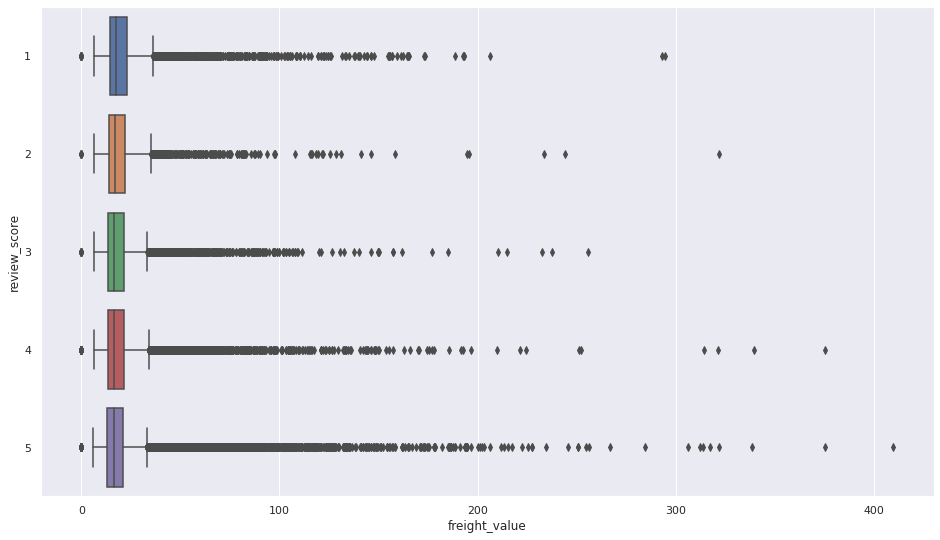

In [ ]:
plt.figure(figsize=(16, 9))
sb.boxplot(data = master, x = "freight_value", y = "review_score", orient = "h")

It can be observed that the higher rating or review score there is little change in its median for the freight value from the box plot above 

### Correlation among predictor and response variables

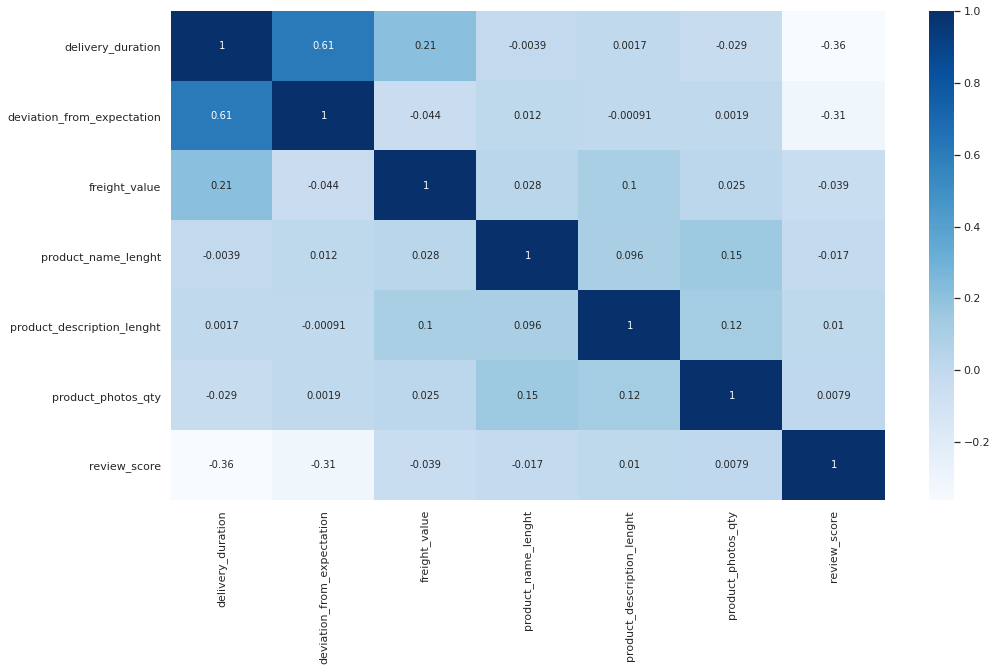

In [ ]:
plt.figure(figsize=(16, 9))
df = pd.DataFrame(master[["delivery_duration", "deviation_from_expectation", "freight_value","product_name_lenght", "product_description_lenght", "product_photos_qty", "review_score"]])
sb.heatmap(df.corr(), cmap = "Blues", annot = True)

From the correlation matrix above, we are able to examine the correlation coefficient between variables and in turn gain a better understanding between the relationship among our predictors and response variables. 


1.   Correlation between review score and delivery duration
*   We observe that there is a negative correlation coefficient of -0.36
*   This indicates that review score and delivery duration have a relatively weak negative correlation
*   This translate to a shorter delivery duration implying that there is a higher probability to obtain a higher star rating.           
 
2.   Correlation between review score and deviation from expectation
*   We observe that there is a negative correlation coefficient of -0.31
*   This indicates that review score and deviation from expectation have a relatively weak negative correlation
*   This translate to a faster delivery done before actual delivery date implying that there is a higher probability to obtain a higher star rating.          


3.   Correlation between review score and length of product name
*   We observe that there is a negative correlation coefficient of -0.017
*   This indicates that review score and length of product name have a weak negative correlation
*   This result may imply that a shorter length of product name may result in a greater probability to obtain a higher star rating. However, the relationship is weak

4.   Correlation between review score and length of product description
* We observe that there is a positive correlation coefficient of 0.01
*   This indicates that review score and length of product description have a weak positive correlation
*   This result may imply that a longer length of product description may result in a greater probability to obtain a higher star rating. However, the relationship is weak

5.   Correlation between review score and number of product photos
* We observe that there is a positive correlation coefficient of 0.0079
*   This indicates that review score and number of product photos have a very weak positive correlation
*   This result may imply that the greater number of  product photos may result in a greater probability to obtain a higher star rating. However, this relationship is very weak and may prove inconclusive

6.   Correlation between review score and freight value
* We observe that there is a negative correlation coefficient of -0.039
*   This indicates that review score and freight value have a weak negative correlation
*   This result may imply that a cheaper freight value may result in a greater probability to obtain a higher star rating. However, the relationship is weak



## Machine Learning

This portion covers the implementation of multiple machine learning models, fitted with the cleaned master data. Comparisons among the the diffent models are done to obtain the best model for our Rating Engine Optimisation goal, to predict a product's rating with the predictors provided.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

Using the decision tree classification model to predict the probability of a product falling into one of the categorical rating from 1 to 5. We split our cleaned dataset into 70% train data and 30% test data for fitting into the decision tree model and observed the classification accuracy and trained decision tree model. We first implemented 6 univariate decision tree models with our 6 predictors.

### Decision Tree 1: Using Delivery Time to Predict Product Rating



In [ ]:
review_score = pd.DataFrame(master["review_score"])             #response(Y)
delivery_duration = pd.DataFrame(master["delivery_duration"])   #predictor(X)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6214511041009464

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6214470284237726



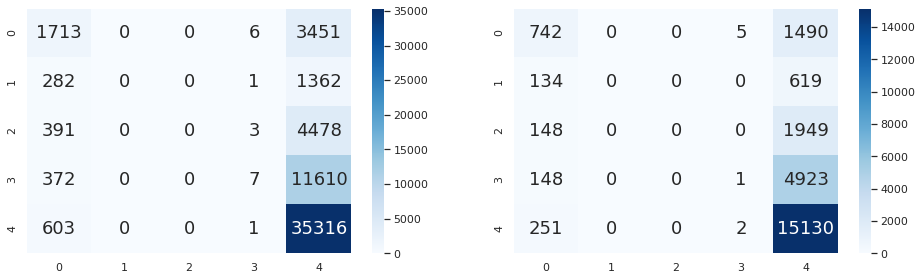

In [ ]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(delivery_duration, review_score, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 5) # create the decision tree object
dectree.fit(X_train, y_train)                   # train the decision tree model

# Predict Product Rating
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(16, 4.5))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", 
           annot_kws={"size": 18}, ax = axes[0], cmap = "Blues")
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f",
           annot_kws={"size": 18}, ax = axes[1], cmap = "Blues")

[Text(352.73571428571427, 597.96, 'Delivery Time <= 24.5\ngini = 0.581\nsamples = 59596\nvalue = [5170, 1645, 4872, 11989, 35920]\nclass = Rating 5'),
 Text(191.31428571428572, 489.24, 'Delivery Time <= 12.5\ngini = 0.545\nsamples = 54926\nvalue = [3149, 1291, 4310, 11334, 34842]\nclass = Rating 5'),
 Text(95.65714285714286, 380.52000000000004, 'Delivery Time <= 6.5\ngini = 0.507\nsamples = 39289\nvalue = [1872, 773, 2706, 7637, 26301]\nclass = Rating 5'),
 Text(47.82857142857143, 271.8, 'Delivery Time <= 2.5\ngini = 0.473\nsamples = 17847\nvalue = [769, 311, 1086, 3202, 12479]\nclass = Rating 5'),
 Text(23.914285714285715, 163.07999999999998, 'Delivery Time <= 1.5\ngini = 0.447\nsamples = 3774\nvalue = [149, 64, 221, 615, 2725]\nclass = Rating 5'),
 Text(11.957142857142857, 54.360000000000014, 'gini = 0.429\nsamples = 1619\nvalue = [62, 28, 83, 254, 1192]\nclass = Rating 5'),
 Text(35.871428571428574, 54.360000000000014, 'gini = 0.46\nsamples = 2155\nvalue = [87, 36, 138, 361, 1533]\n

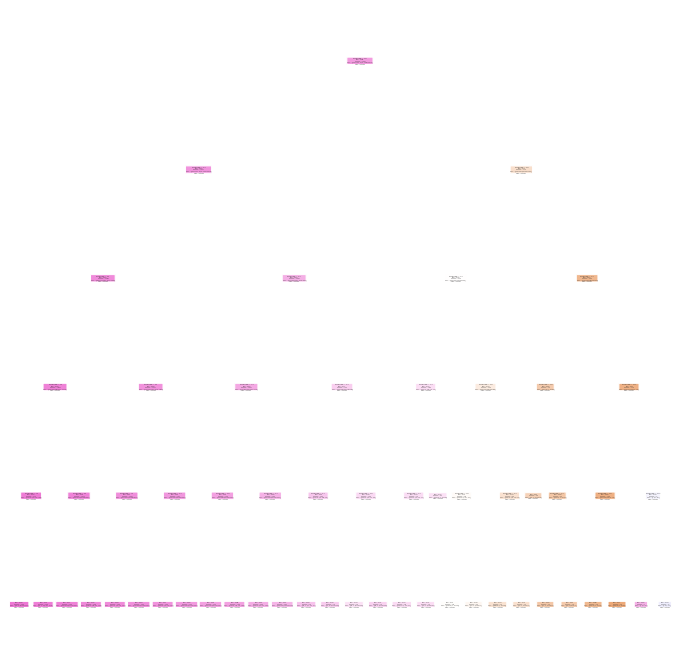

In [ ]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(12,12))
plot_tree(dectree, filled = True, rounded = True, 
          feature_names = ["Delivery Time"], class_names = ["Rating 1", "Rating 2", "Rating 3", "Rating 4", "Rating 5"])

### Decision Tree 2: Using Deviation from Estimated Delivery Date to Predict Product Rating

In [ ]:
review_score = pd.DataFrame(master["review_score"])                             #response(Y)
deviation_from_expectation = pd.DataFrame(master["deviation_from_expectation"]) #predictor(X)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.633633129740251

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6259102654451492



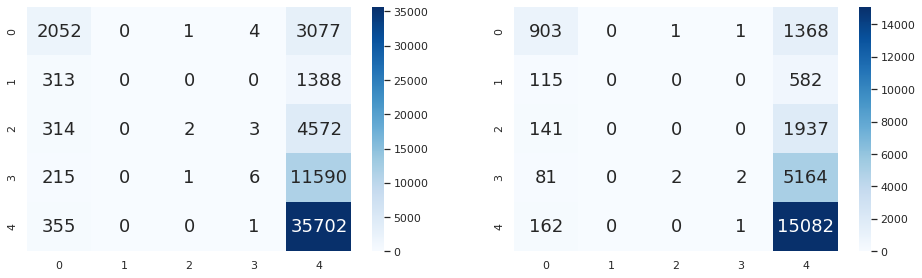

In [ ]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(deviation_from_expectation , review_score, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 5)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Product Rating
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(16, 4.5))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", 
           annot_kws={"size": 18}, ax = axes[0], cmap = "Blues")
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f",
           annot_kws={"size": 18}, ax = axes[1], cmap = "Blues")

[Text(334.8, 597.96, 'Deviation from Estimated Delivery Date <= 1.5\ngini = 0.58\nsamples = 59596\nvalue = [5134, 1701, 4891, 11812, 36058]\nclass = Rating 5'),
 Text(207.25714285714287, 489.24, 'Deviation from Estimated Delivery Date <= -6.5\ngini = 0.543\nsamples = 55986\nvalue = [2987, 1357, 4516, 11518, 35608]\nclass = Rating 5'),
 Text(119.57142857142857, 380.52000000000004, 'Deviation from Estimated Delivery Date <= -11.5\ngini = 0.527\nsamples = 46859\nvalue = [2381, 1025, 3508, 9422, 30523]\nclass = Rating 5'),
 Text(63.77142857142857, 271.8, 'Deviation from Estimated Delivery Date <= -17.5\ngini = 0.516\nsamples = 32316\nvalue = [1601, 678, 2352, 6290, 21395]\nclass = Rating 5'),
 Text(31.885714285714286, 163.07999999999998, 'Deviation from Estimated Delivery Date <= -25.5\ngini = 0.508\nsamples = 13557\nvalue = [686, 270, 974, 2541, 9086]\nclass = Rating 5'),
 Text(15.942857142857143, 54.360000000000014, 'gini = 0.525\nsamples = 3347\nvalue = [190, 69, 237, 665, 2186]\nclass 

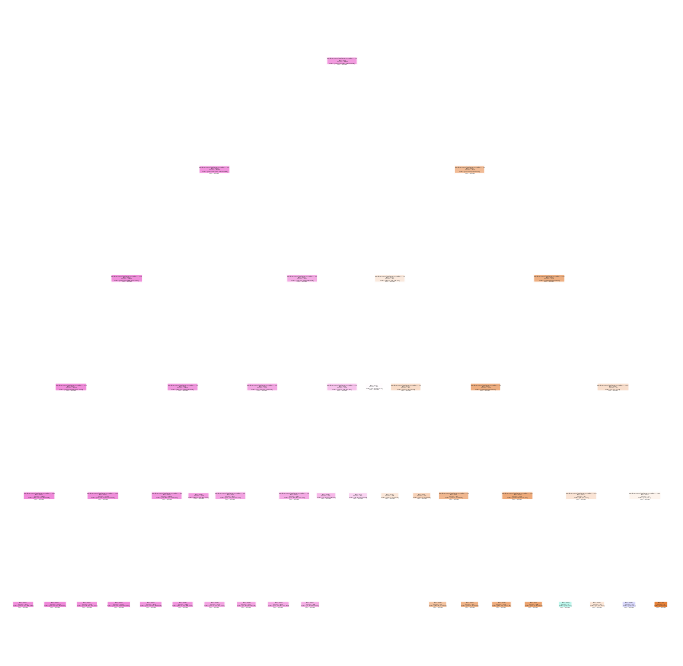

In [ ]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(12,12))
plot_tree(dectree, filled = True, rounded = True, 
          feature_names = ["Deviation from Estimated Delivery Date"], class_names = ["Rating 1", "Rating 2", "Rating 3", "Rating 4", "Rating 5"])

### Decision Tree 3: Using Length of Product Name to Predict Product Rating


In [ ]:
review_score = pd.DataFrame(master["review_score"])                             #response(Y)
product_name_lenght = pd.DataFrame(master["product_name_lenght"]) #predictor(X)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6029767098462984

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6016756714431133



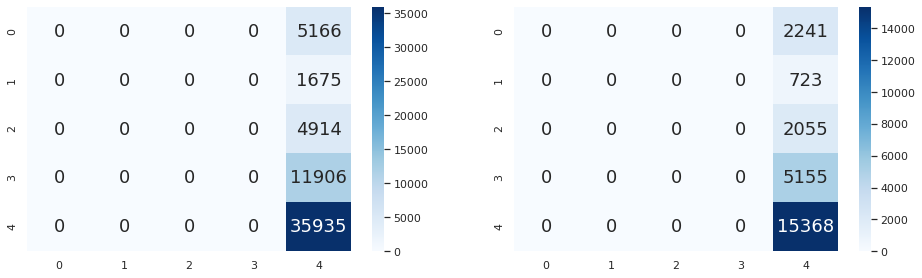

In [ ]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(product_name_lenght, review_score, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 5)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Product Rating
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(16, 4.5))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", 
           annot_kws={"size": 18}, ax = axes[0], cmap = "Blues")
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f",
           annot_kws={"size": 18}, ax = axes[1], cmap = "Blues")

[Text(347.355, 597.96, 'Length of Product Name <= 53.5\ngini = 0.581\nsamples = 59596\nvalue = [5166, 1675, 4914, 11906, 35935]\nclass = Rating 5'),
 Text(205.06500000000003, 489.24, 'Length of Product Name <= 32.5\ngini = 0.572\nsamples = 33687\nvalue = [2873, 938, 2668, 6552, 20656]\nclass = Rating 5'),
 Text(125.55000000000001, 380.52000000000004, 'Length of Product Name <= 26.5\ngini = 0.551\nsamples = 4495\nvalue = [375, 101, 329, 843, 2847]\nclass = Rating 5'),
 Text(66.96000000000001, 271.8, 'Length of Product Name <= 18.5\ngini = 0.57\nsamples = 1780\nvalue = [149, 41, 142, 357, 1091]\nclass = Rating 5'),
 Text(33.480000000000004, 163.07999999999998, 'Length of Product Name <= 15.5\ngini = 0.532\nsamples = 309\nvalue = [22, 8, 21, 57, 201]\nclass = Rating 5'),
 Text(16.740000000000002, 54.360000000000014, 'gini = 0.617\nsamples = 117\nvalue = [12, 4, 10, 25, 66]\nclass = Rating 5'),
 Text(50.220000000000006, 54.360000000000014, 'gini = 0.471\nsamples = 192\nvalue = [10, 4, 11, 

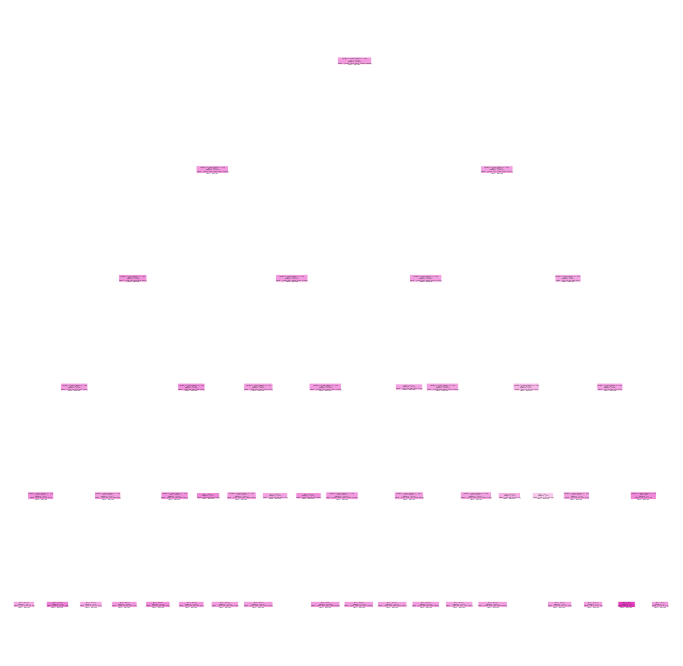

In [ ]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(12,12))
plot_tree(dectree, filled = True, rounded = True, 
          feature_names = ["Length of Product Name"], class_names = ["Rating 1", "Rating 2", "Rating 3", "Rating 4", "Rating 5"])

### Decision Tree 4: Using Length of Product Description to Predict Product Rating

In [ ]:
review_score = pd.DataFrame(master["review_score"])             #response(Y)
product_description_lenght = pd.DataFrame(master["product_description_lenght"]) #predictor(X)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6026746761527619

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6024195442800094



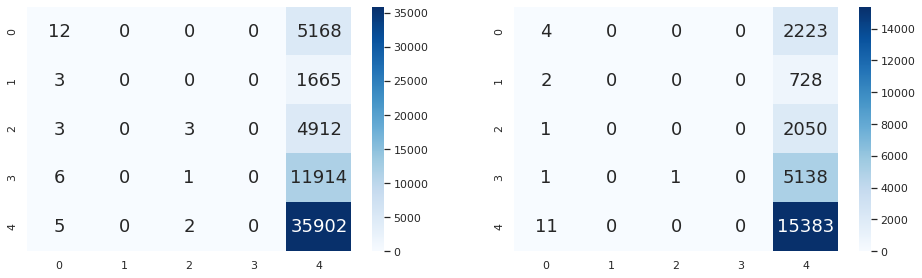

In [ ]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(product_description_lenght , review_score, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 5)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Product Rating
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(16, 4.5))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", 
           annot_kws={"size": 18}, ax = axes[0], cmap = "Blues")
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f",
           annot_kws={"size": 18}, ax = axes[1], cmap = "Blues")

[Text(303.8, 597.96, 'Length of product description <= 319.5\ngini = 0.582\nsamples = 59596\nvalue = [5180, 1668, 4918, 11921, 35909]\nclass = Rating 5'),
 Text(136.4, 489.24, 'Length of product description <= 311.5\ngini = 0.597\nsamples = 12275\nvalue = [1159, 363, 1083, 2459, 7211]\nclass = Rating 5'),
 Text(80.60000000000001, 380.52000000000004, 'Length of product description <= 73.5\ngini = 0.593\nsamples = 11698\nvalue = [1097, 337, 1008, 2337, 6919]\nclass = Rating 5'),
 Text(49.6, 271.8, 'Length of product description <= 68.5\ngini = 0.509\nsamples = 358\nvalue = [28, 12, 29, 46, 243]\nclass = Rating 5'),
 Text(24.8, 163.07999999999998, 'Length of product description <= 29.0\ngini = 0.528\nsamples = 301\nvalue = [23, 10, 26, 43, 199]\nclass = Rating 5'),
 Text(12.4, 54.360000000000014, 'gini = 0.153\nsamples = 12\nvalue = [0, 0, 0, 1, 11]\nclass = Rating 5'),
 Text(37.2, 54.360000000000014, 'gini = 0.54\nsamples = 289\nvalue = [23, 10, 26, 42, 188]\nclass = Rating 5'),
 Text(74

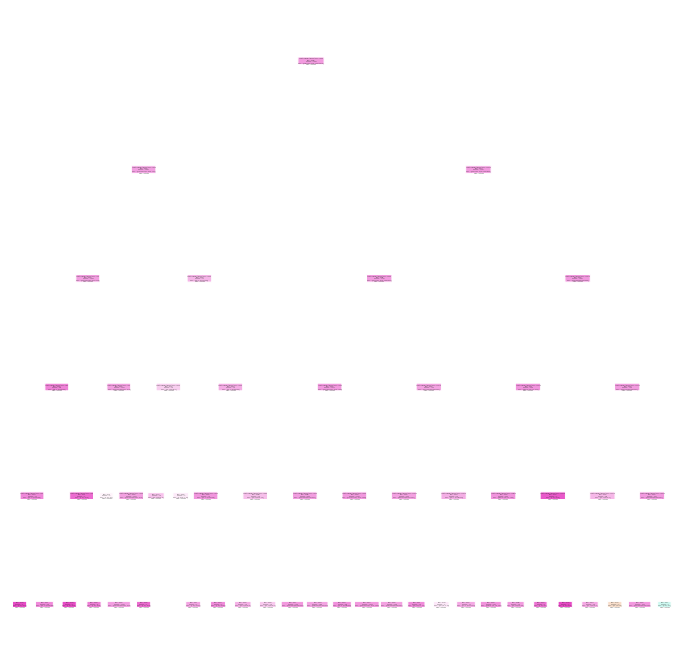

In [ ]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(12,12))
plot_tree(dectree, filled = True, rounded = True, 
          feature_names = ["Length of product description"], class_names = ["Rating 1", "Rating 2", "Rating 3", "Rating 4", "Rating 5"])

### Decision Tree 5: Using Number of Product Photos to Predict Product Rating



In [ ]:
review_score = pd.DataFrame(master["review_score"])             #response(Y)
product_photos_qty = pd.DataFrame(master["product_photos_qty"]) #predictor(X)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6012987448822069

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6055516404353614



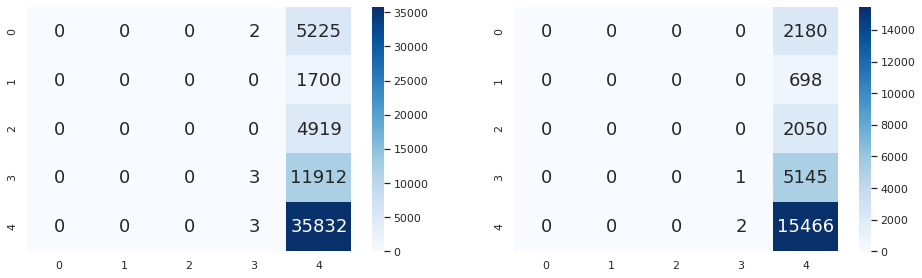

In [ ]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(product_photos_qty , review_score, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 5)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Product Rating
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(16, 4.5))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", 
           annot_kws={"size": 18}, ax = axes[0], cmap = "Blues")
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f",
           annot_kws={"size": 18}, ax = axes[1], cmap = "Blues")

[Text(232.50000000000003, 597.96, 'Number of Product Photos <= 1.5\ngini = 0.583\nsamples = 59596\nvalue = [5227, 1700, 4919, 11915, 35835]\nclass = Rating 5'),
 Text(195.3, 489.24, 'gini = 0.586\nsamples = 28915\nvalue = [2663, 839, 2415, 5679, 17319]\nclass = Rating 5'),
 Text(269.70000000000005, 489.24, 'Number of Product Photos <= 6.5\ngini = 0.58\nsamples = 30681\nvalue = [2564, 861, 2504, 6236, 18516]\nclass = Rating 5'),
 Text(148.8, 380.52000000000004, 'Number of Product Photos <= 5.5\ngini = 0.581\nsamples = 28811\nvalue = [2408, 805, 2337, 5905, 17356]\nclass = Rating 5'),
 Text(111.60000000000001, 271.8, 'Number of Product Photos <= 4.5\ngini = 0.579\nsamples = 26731\nvalue = [2242, 735, 2153, 5451, 16150]\nclass = Rating 5'),
 Text(74.4, 163.07999999999998, 'Number of Product Photos <= 3.5\ngini = 0.58\nsamples = 23548\nvalue = [2001, 662, 1907, 4767, 14211]\nclass = Rating 5'),
 Text(37.2, 54.360000000000014, 'gini = 0.579\nsamples = 18819\nvalue = [1587, 515, 1491, 3852, 

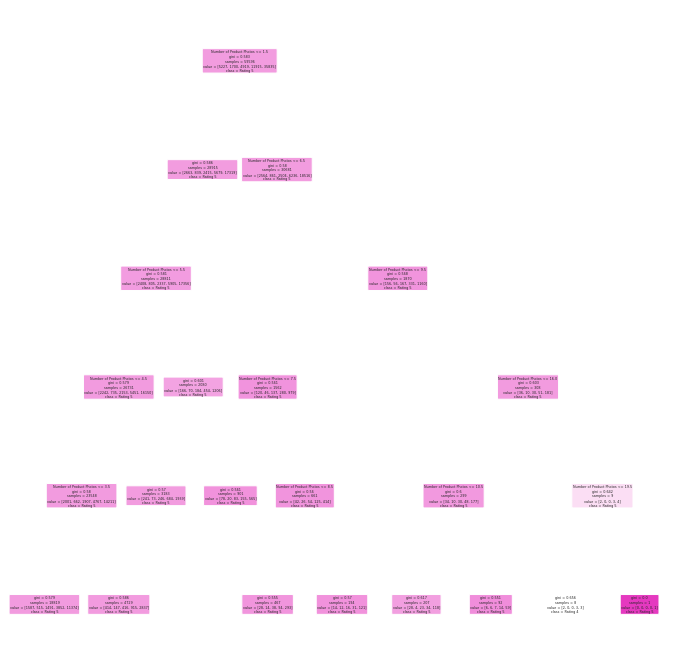

In [ ]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(12,12))
plot_tree(dectree, filled = True, rounded = True, 
          feature_names = ["Number of Product Photos"], class_names = ["Rating 1", "Rating 2", "Rating 3", "Rating 4", "Rating 5"])

### Decision Tree 6: Using Freight Value to Predict Product Rating

In [ ]:
review_score = pd.DataFrame(master["review_score"])     #response(Y)
freight_value = pd.DataFrame(master["freight_value"])   #predictor(X)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6023894221088664

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6031634171169055



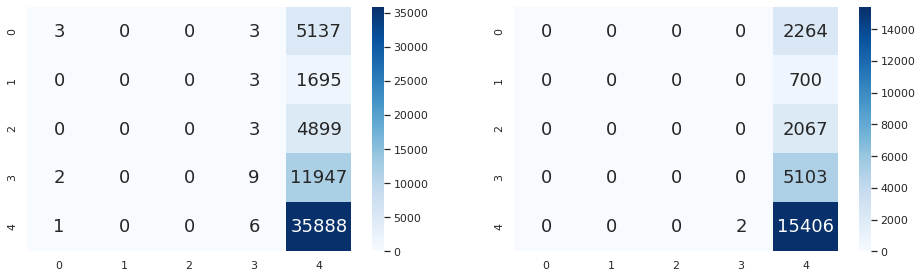

In [ ]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(freight_value , review_score, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 5)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Product Rating
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(16, 4.5))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", 
           annot_kws={"size": 18}, ax = axes[0], cmap = "Blues")
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f",
           annot_kws={"size": 18}, ax = axes[1], cmap = "Blues")

[Text(310.1823529411765, 597.96, 'Freight Value <= 14.095\ngini = 0.582\nsamples = 59596\nvalue = [5143, 1698, 4902, 11958, 35895]\nclass = Rating 5'),
 Text(131.29411764705884, 489.24, 'Freight Value <= 10.685\ngini = 0.547\nsamples = 17081\nvalue = [1137, 437, 1305, 3342, 10860]\nclass = Rating 5'),
 Text(59.082352941176474, 380.52000000000004, 'Freight Value <= 6.205\ngini = 0.53\nsamples = 7821\nvalue = [499, 191, 549, 1490, 5092]\nclass = Rating 5'),
 Text(26.258823529411767, 271.8, 'Freight Value <= 2.85\ngini = 0.427\nsamples = 215\nvalue = [5, 5, 6, 42, 157]\nclass = Rating 5'),
 Text(13.129411764705884, 163.07999999999998, 'gini = 0.431\nsamples = 212\nvalue = [5, 5, 6, 42, 154]\nclass = Rating 5'),
 Text(39.38823529411765, 163.07999999999998, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 0, 0, 3]\nclass = Rating 5'),
 Text(91.90588235294119, 271.8, 'Freight Value <= 7.935\ngini = 0.533\nsamples = 7606\nvalue = [494, 186, 543, 1448, 4935]\nclass = Rating 5'),
 Text(65.6470588235294

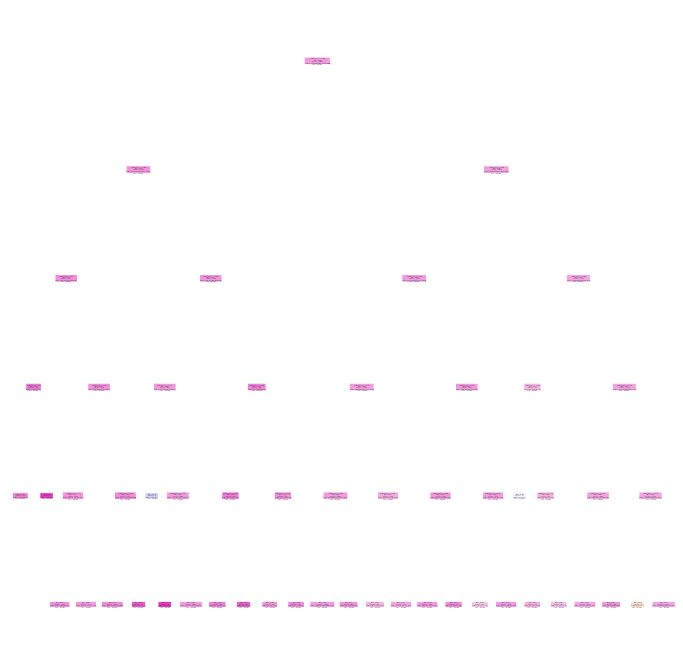

In [ ]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(12,12))
plot_tree(dectree, filled = True, rounded = True, 
          feature_names = ["Freight Value"], class_names = ["Rating 1", "Rating 2", "Rating 3", "Rating 4", "Rating 5"])

### Multivariate Decision Tree: Using All Variables to Predict Product Rating

With all the relevant predictors, we implemented a multivariate decision tree model to predict product rating given multiple different variable that constitutes the different marketing and customer service factors. The model was trained and had a good classification accuracy.

In [ ]:
X = pd.DataFrame(master[["delivery_duration", "deviation_from_expectation", "product_name_lenght", "product_description_lenght", "product_photos_qty","freight_value"]]) #Predictor (X)
y = pd.DataFrame(master["review_score"].astype('category')) #Response (Y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6301765219142225

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6343277738626576



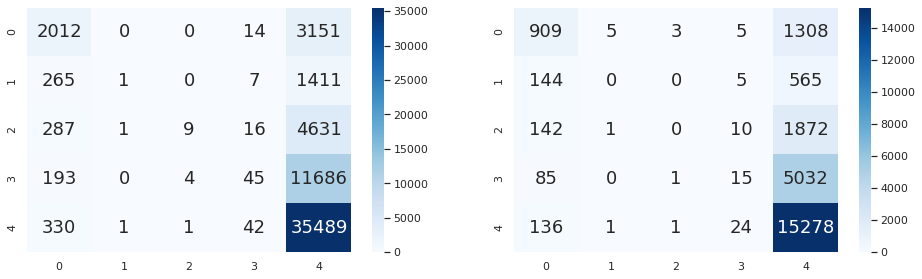

In [ ]:
# Decision Tree using Train Data of depth 5
dectree_d2 = DecisionTreeClassifier(max_depth = 5)  # create the decision tree object
dectree_d2.fit(X_train, y_train)                    # train the decision tree model

# Predict Product Rating
y_train_pred = dectree_d2.predict(X_train)
y_test_pred = dectree_d2.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree_d2.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree_d2.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(16, 4.5))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0], cmap = "Blues")
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1], cmap = "Blues")

[Text(334.8, 597.96, 'deviation_from_expectation <= 2.5\ngini = 0.583\nsamples = 59596\nvalue = [5177, 1684, 4944, 11928, 35863]\nclass = Rating 5'),
 Text(167.4, 489.24, 'delivery_duration <= 15.5\ngini = 0.55\nsamples = 56389\nvalue = [3144, 1403, 4632, 11715, 35495]\nclass = Rating 5'),
 Text(83.7, 380.52000000000004, 'delivery_duration <= 9.5\ngini = 0.519\nsamples = 45872\nvalue = [2260, 956, 3331, 9140, 30185]\nclass = Rating 5'),
 Text(41.85, 271.8, 'delivery_duration <= 3.5\ngini = 0.496\nsamples = 30224\nvalue = [1357, 596, 2006, 5729, 20536]\nclass = Rating 5'),
 Text(20.925, 163.07999999999998, 'freight_value <= 7.855\ngini = 0.451\nsamples = 6347\nvalue = [249, 121, 351, 1069, 4557]\nclass = Rating 5'),
 Text(10.4625, 54.360000000000014, 'gini = 0.5\nsamples = 1456\nvalue = [78, 26, 88, 281, 983]\nclass = Rating 5'),
 Text(31.387500000000003, 54.360000000000014, 'gini = 0.436\nsamples = 4891\nvalue = [171, 95, 263, 788, 3574]\nclass = Rating 5'),
 Text(62.775000000000006, 1

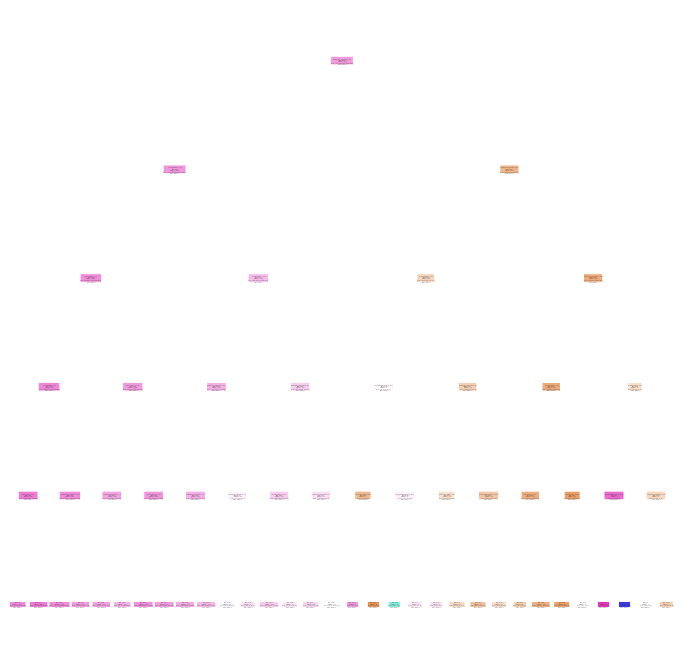

In [ ]:
#Print multi-variate decision tree
f = plt.figure(figsize=(12,12))
plot_tree(dectree_d2, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names = ["Rating 1", "Rating 2", "Rating 3", "Rating 4", "Rating 5"])

Upon inspection of our results we discovered a startling result that rendered our multivariate decision less effective. Due to the imbalanced count of review scores with a high median of 5 and mean of about 4.2 previously mentioned in our exploratory analysis, accuracy classification and confusion matrix delivered positive results for the previous model fitted where prediction of review score is either 1 or 5. As a result of training and testing our machine learning model from the clean imbalanced dataset, products predicted to be in either rating 1 or 5 were classified to be true positive and we were unable to obtain accurate predictions for review score that were different from 1 and 5. 

In order to remedy the imbalanced dataset, we employed the use of random oversampling to duplicate and balance our dataset for accurate rating prediction among the 5 rating categories **" 1 ", " 2 ", " 3 ", " 4 " and " 5 ".**

### Random Oversampling

With the use of random oversampling our cleaned dataframe produced a new dataframe with balanced distribution among the rating categories **" 1 ", " 2 ", " 3 ", " 4 " and " 5 ".**

In [ ]:
# Perform random over-sampling
rating_1 = master[master["review_score"] == 1]
rating_2 = master[master["review_score"] == 2]
rating_3 = master[master["review_score"] == 3]
rating_4 = master[master["review_score"] == 4]
rating_5 = master[master["review_score"] == 5]

rating_1_oversampled = resample(rating_1, replace = True, n_samples = rating_5.shape[0])
rating_2_oversampled = resample(rating_2, replace = True, n_samples = rating_5.shape[0])
rating_3_oversampled = resample(rating_3, replace = True, n_samples = rating_5.shape[0])
rating_4_oversampled = resample(rating_4, replace = True, n_samples = rating_5.shape[0])
master_oversampled = pd.concat([rating_1_oversampled, rating_2_oversampled, rating_3_oversampled, rating_4_oversampled, rating_5])

In [ ]:
master_oversampled["review_score"].value_counts()

5    51303
4    51303
3    51303
2    51303
1    51303
Name: review_score, dtype: int64

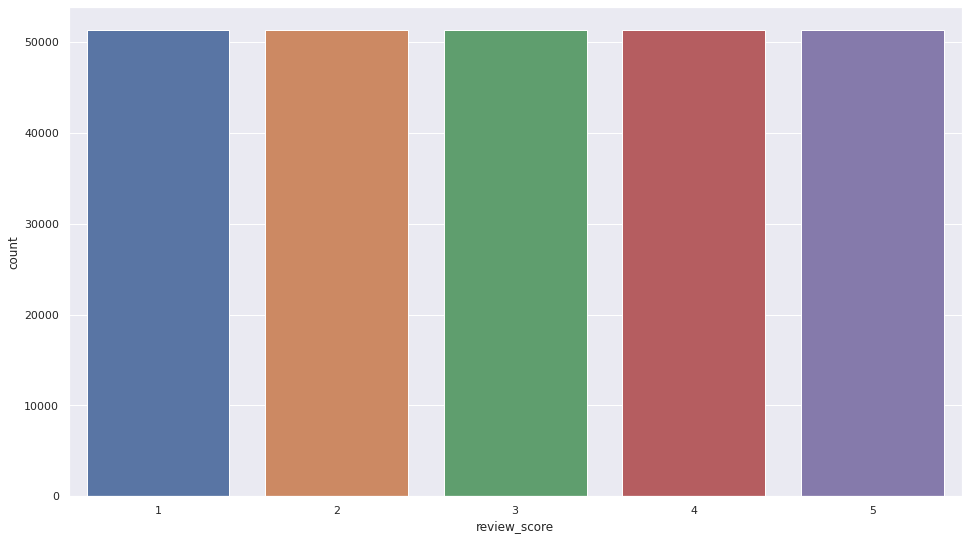

In [ ]:
plt.figure(figsize=(16, 9))
sb.countplot(data = master_oversampled, x = "review_score")

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.3143350412118512

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.31571697745435645



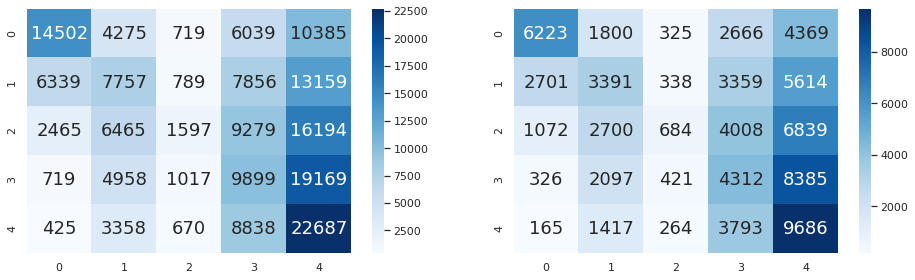

In [ ]:
# Extract Response and Predictors
X = pd.DataFrame(master_oversampled[["delivery_duration", "deviation_from_expectation", "product_name_lenght", "product_description_lenght", "product_photos_qty", "freight_value"]])
y = pd.DataFrame(master_oversampled["review_score"].astype('category'))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 5)
dectree.fit(X_train, y_train)

# Predict Product Rating
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(16, 4.5))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", 
           annot_kws={"size": 18}, ax = axes[0], cmap = "Blues")
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f",
           annot_kws={"size": 18}, ax = axes[1], cmap = "Blues")

[Text(344.565, 597.96, 'X[1] <= 1.5\ngini = 0.8\nsamples = 179560\nvalue = [35920, 35900, 36000, 35762, 35978]'),
 Text(178.56, 489.24, 'X[0] <= 15.5\ngini = 0.794\nsamples = 153551\nvalue = [21013, 28852, 33224, 34965, 35497]'),
 Text(89.28, 380.52000000000004, 'X[0] <= 7.5\ngini = 0.79\nsamples = 117275\nvalue = [15352, 20210, 24083, 27402, 30228]'),
 Text(44.64, 271.8, 'X[2] <= 53.5\ngini = 0.785\nsamples = 54459\nvalue = [6916, 8918, 10505, 12533, 15587]'),
 Text(22.32, 163.07999999999998, 'X[3] <= 2163.0\ngini = 0.779\nsamples = 29421\nvalue = [3559, 4479, 5456, 6921, 9006]'),
 Text(11.16, 54.360000000000014, 'gini = 0.78\nsamples = 28499\nvalue = [3434, 4453, 5326, 6656, 8630]'),
 Text(33.480000000000004, 54.360000000000014, 'gini = 0.712\nsamples = 922\nvalue = [125, 26, 130, 265, 376]'),
 Text(66.96000000000001, 163.07999999999998, 'X[3] <= 120.5\ngini = 0.791\nsamples = 25038\nvalue = [3357, 4439, 5049, 5612, 6581]'),
 Text(55.8, 54.360000000000014, 'gini = 0.765\nsamples = 79

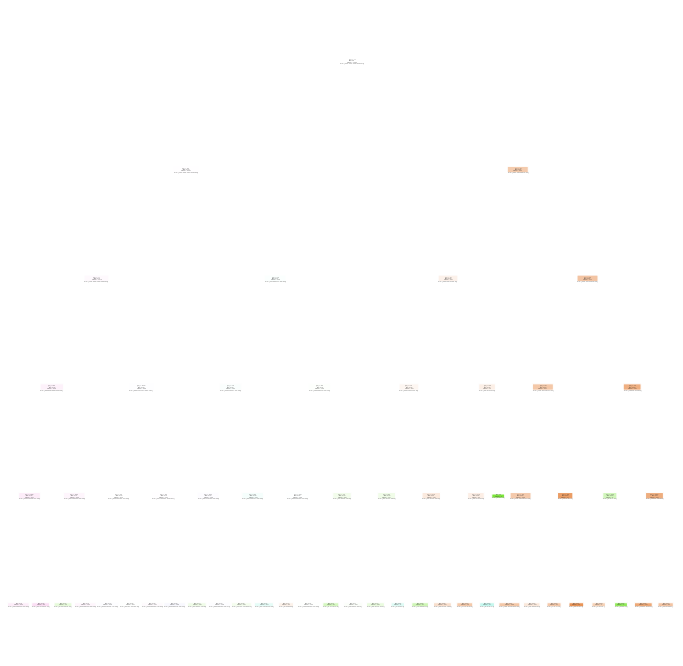

In [ ]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(12,12))
plot_tree(dectree, filled=True, rounded=True)

With the balanced data, we were finally able to train our decision tree model to predict ratings among the 5 different categories. This enabled us to implement a program to predict the rating of a product from 1 to 5 with the relavant predictors for rating optimisation.

### Random Forest

Utilising a large number of relatively uncorrelated decision tree models to form a prediction, we are able to outperform any of the individual models. Therefore, we employ the use of the random forest machine learning model to produce a more stable prediction for our ratings.

#### Cross-Validation

In order to maximize accuracy of the classifier on the test set in general as well as to resolve the issue of over-fitting, we used cross-validation to obtain the most optimal hyper-parameter to fit into our random forest machine learning model. 

After cross-validation, the estimate of depth 8 and 300 n_estimators are found to be the most optimal for use in our random forest model.

In [ ]:
# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Extract Response and Predictors
y = pd.DataFrame(master_oversampled["review_score"])
X = pd.DataFrame(master_oversampled[["delivery_duration", "deviation_from_expectation", "product_name_lenght", "product_photos_qty", "freight_value"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,501,100),   # number of trees 100, 200, ..., 500
              'max_depth': np.arange(2, 9)}             # depth of trees 2, 3, 4, 5, ..., 8

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.review_score.ravel())

In [ ]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

Random Forest implementation was done with max_depth = 8 and n_estimator = 300.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.3656048117620851

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.3577415372620363



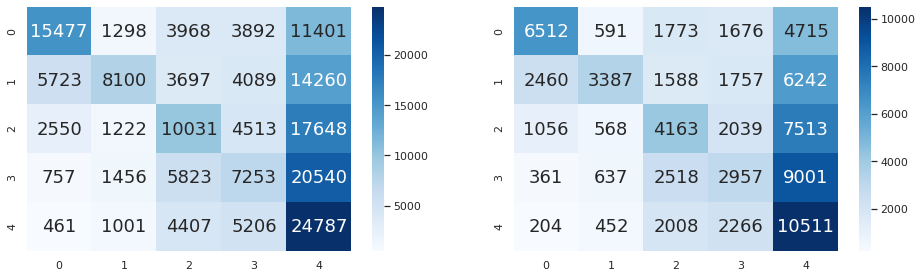

In [ ]:
# Extract Response and Predictors
X = pd.DataFrame(master_oversampled[["delivery_duration", "deviation_from_expectation", "product_name_lenght", "product_description_lenght", "product_photos_qty", "freight_value"]])
y = pd.DataFrame(master_oversampled["review_score"].astype('category'))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 300,  # from cross-validation
                                 max_depth = 8)       # from cross-validation

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train)

# Predict Product Rating
y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", rforest.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", rforest.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(16, 4.5))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", 
           annot_kws={"size": 18}, ax = axes[0], cmap = "Blues")
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f",
           annot_kws={"size": 18}, ax = axes[1], cmap = "Blues")

## Data-Driven Insights and Recommendations


In conclusion, we have surmised that the random forest machine learning model with random oversampling data allows us to develop the most optimal program that effectively predict the rating for an item given the following: duration of product delivery, deviation from expected to actual delivery date, length of product name, length of product description, quantity of product photos and freight value. We believe that our findings can be utilised by ecommerce companies to allocate the relevant resources to optimise their rating. Quality rating will in turn drive more organic growth and improve conversion rate for their business.  